#Imports and Libraries

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd

from xgboost import XGBRegressor
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel
from sklearn.linear_model import LinearRegression,Ridge,Lasso #Ridge: Regularisasi L2 (cegah satu fitur untuk punya efek dominan), Lasso: regularisasi L1, regularisasi biasa
from sklearn.tree import DecisionTreeRegressor #Tree model untuk regresi
from sklearn.ensemble import RandomForestRegressor #Random forest
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import OneHotEncoder

## Helper Functions

one-hot encoding the area name includes another csv, 'area_names.csv' which is available on github. The cleaned dataset only contains 13 or so distinct categorical values from field 'area_name', while the actual uncleaned data contains around 25. In order to compensate for future occurences where the locations aren't involved in the distinct 13 values that are trained upon, we initialize all 25 distinct values as one-hot values.

In [2]:
def oneHotEncodeAreaName(dataset, area_names_csv):
  area_names_df = pd.read_csv(area_names_csv) # Obtains area_names.csv, a csv file containing all 25 distinct location names in which only 13 exists in the clean data.
  area_names =area_names_df['area_names'].tolist()

  column_to_encode = 'area_name'
  encoder = OneHotEncoder(sparse=False, categories=[area_names])
  encoded_columns = encoder.fit_transform(pd.DataFrame(area_names, columns=['area_name']))
  one_hot_encoded_places = encoder.transform(dataset[['area_name']])
  one_hot_encoded_df = pd.DataFrame(one_hot_encoded_places, columns=encoder.get_feature_names_out(['area_name']))

  dataset = data.drop(columns=[column_to_encode])
  dataset = pd.concat([data, one_hot_encoded_df], axis=1)
  return dataset

In [3]:
def load_dataset(dataset):
  #Function that can receive csv data, turn the features and labels into numpy variables, and returns a tuple of (X, y)
  X = dataset.drop(columns=['average_baseline_price']).values
  y = dataset['average_baseline_price'].values
  return (X,y)

In [4]:
def TrainFitPredict(model,iterations,X, y,X_test ,y_test): #Takes in split dataset, returns test scores and train history.
  model.fit(X,y)
  test_score = np.zeros((iterations,), dtype=np.float64)
  for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)
  return test_score, model.train_score_

In [5]:
def PlotPerformance(test_scores, train_scores): #plots training + test by receiving test and training scores provided by TrainFitPredict
  fig = plt.figure(figsize=(6, 6))
  plt.subplot(1, 1, 1)
  plt.title("MSE")
  plt.plot(
      np.arange(len(train_scores)) + 1,
      train_scores,
      "b-",
      label="Training Set Deviance",
  )
  plt.plot(
      np.arange(len(test_scores)) + 1, test_scores, "r-", label="Test Set Deviance"
  )
  plt.legend(loc="upper right")
  plt.xlabel("Boosting Iterations")
  plt.ylabel("Deviance")
  fig.tight_layout()
  plt.show()

In [54]:
def ShowError(trained_model, X_test, y_test):
  mae = mean_absolute_error(y_test, trained_model.predict(X_test))
  print(mae)

In [71]:
def GetModelMAE(trained_model, X_test, y_test):
  mae = mean_absolute_error(y_test, trained_model.predict(X_test))
  return mae

#Load and Train data

Load the data, drop the unit_id field, one-hot encodes the area name.

In [19]:
df = pd.read_csv("/content/CLEAN_UnitToAverageBaselinePrice.csv")
data = df.drop(columns=['unit_id'])
data = oneHotEncodeAreaName(data,'/content/area_names.csv' )
data = data.drop(columns=['area_name'])
dataset = load_dataset(data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training Parameters

### GradientBoostingRegressor

In [80]:
TEST_RATIO = 0.25
RANDOM_STATE = 123
params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [21]:
X, y = dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE)

In [41]:
X_train.shape

(657, 54)

## Scikit Models

In [82]:
LR = LinearRegression()
DTR = DecisionTreeRegressor(random_state=RANDOM_STATE)
RFR = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)
XGB = XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
GBR = ensemble.GradientBoostingRegressor(**params)
ModelsList = [GBR,
              XGB,
              RFR,
              DTR,
              LR,]
modelMAEs = []
for model in ModelsList:
  model.fit(X_train,y_train)
  modelMAEs.append((model.__class__.__name__, GetModelMAE(model, X_test, y_test)))
print(modelMAEs)

[('GradientBoostingRegressor', 335170.123117225), ('XGBRegressor', 367295.5107800531), ('RandomForestRegressor', 321067.9437453729), ('DecisionTreeRegressor', 364466.32643919147), ('LinearRegression', 404682.0225275272)]


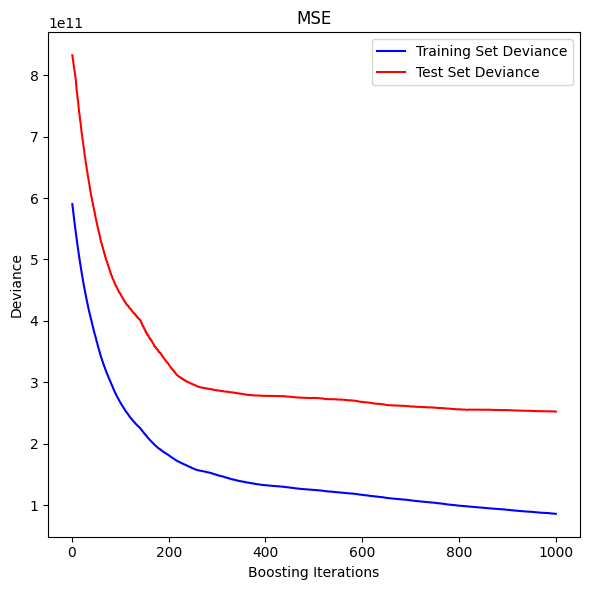

In [22]:
reg = ensemble.GradientBoostingRegressor(**params)
test_scores, train_scores = TrainFitPredict(reg, params['n_estimators'], X_train, y_train, X_test, y_test) #All datas are in ndarrays.
PlotPerformance(test_scores, train_scores)

In [53]:
ShowError(reg, X_test, y_test)

335003.46720418055


### XGBoost

In [52]:
xgbr = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1)
xgbr.fit(X_train,y_train)
ShowError(xgbr, X_test, y_test)

421727.6295992884


### Random Forest Regressor

In [55]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)
RFR.fit(X_train,y_train)


321498.9235957683


In [56]:
ShowError(RFR, X_test, y_test)

321498.9235957683


### Decision Tree Regressor

In [68]:
DTR = DecisionTreeRegressor(random_state=RANDOM_STATE)
DTR.fit(X_train, y_train)

DecisionTreeRegressor(random_state=37)

In [69]:
ShowError(DTR, X_test,y_test)

364587.5084147086


### Linear Regression

In [57]:
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [58]:
ShowError(LR, X_test,y_test)

404682.0225275272
